In [1]:
#from typing import List, Tuple
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

def domain(n,pars):

    t = np.random.uniform(low=0,high=pars['tf'],size=(n,1))
    x = np.random.uniform(low=pars['xi'],high=pars['xf'],size=(n,1))

    X = np.hstack((t,x))

    return X

class MLP(nn.Module):
    
    # Define the MLP

    def __init__(
        self, pars, device
    ) -> None:

        super().__init__()

        # Add number of MLP input and outputs to the layers list
        layers = [2,*pars['layers'],2]
        
        # Built the MLP
        modules = []
        for _in, _out in list(zip(layers, layers[1:])):
            modules.append(nn.Linear(_in, _out))
            modules.append(ResidualBlock(_out))
        
        # Remove last block
        modules.pop()

        self.model = nn.Sequential(*modules)

    def forward(self, X: torch.Tensor) -> torch.Tensor:

        # Forward pass
        Y_n = self.model(X)
        Y_p = self.particular_solution(X)
        D = self.boundary_distance(X)

        return D * Y_n + (1-D) * Y_p

    def particular_solution(self,X):
        x = X[:,1].reshape(-1, 1)

        u = torch.sin(np.pi*((1+x)/2))

        return u

    def boundary_distance(self,X):

        alpha = 26.4 # Reaches 0.99 at t = 0.1
        #alpha = 10.56 # Reaches 0.99 at t = 0.25

        t = X[:,0].reshape(-1, 1)
        x = X[:,1].reshape(-1, 1)

        dt = torch.tanh(t*alpha)
        dx = 4*(0.5*x+0.5)*(1-(0.5*x+0.5))

        return torch.hstack((dt*dx,dt*dx))

class ResidualBlock(nn.Module):

    # Define a block with two layers and a residual connection
    def __init__(self,_size:int):
        super().__init__()
        self.Layer1 = nn.Tanh()
        self.Linear = nn.Linear(_size, _size)
        self.Layer2 = nn.Tanh()

    def forward(self,x):
        return x + self.Layer2(self.Linear(self.Layer1(x)))

class PINN:
    def __init__(self, nf, pars: dict, device: torch.device = 'cuda') -> None:

        # Parameters
        self.pars = pars
        self.device = device
        self.nf = nf
        self.nu = pars['nu']

        self.ls_f1 = torch.tensor(0).to(self.device)
        self.ls_f2 = torch.tensor(0).to(self.device)
        self.ls_f = torch.tensor(0).to(self.device)
        self.ls_s = torch.tensor(0).to(self.device)

        # Sample points
        self.sample_points()
        self.zeros = torch.zeros(self.X_f.shape).to(self.device)

        # Initialize Network
        self.net = MLP(pars,device)
        self.net = self.net.to(device)

        if pars['loss_type'] == 'l1':
            self.loss = nn.L1Loss().to(device)
        elif pars['loss_type'] == 'mse':
            self.loss = nn.MSELoss().to(device)

        self.min_ls_tol = 0.01
        self.min_ls_wait = 10000
        self.min_ls_window = 1000

        self.start_time = time.time()

        self.ls = 0
        self.iter = 0

        self.ls_hist = np.zeros((pars['epochs'],2))

        # Optimizer parameters
        if pars['opt_method'] == 'adam':
            self.optimizer = torch.optim.Adam(self.net.parameters(),lr=pars['opt_lr'])
        elif pars['opt_method'] == 'lbfgs':
            self.optimizer = torch.optim.LBFGS(self.net.parameters(),lr=pars['opt_lr'])
        elif pars['opt_method'] == 'sgd':
            self.optimizer = torch.optim.SGD(self.net.parameters(),lr=pars['opt_lr'])
        else:
            raise Exception("Unknown optimization method")

    def sample_points(self):
        X_f = domain(self.nf,self.pars)
        self.X_f = torch.tensor(X_f,dtype=torch.float,requires_grad=True).to(self.device)

    def eq_loss(self, X: torch.Tensor):

        # Forward pass
        t = X[:,0].reshape(-1, 1)
        x = X[:,1].reshape(-1, 1)
        Y = self.net(torch.hstack((t,x)))
        
        u = Y[:,0].reshape(-1, 1)

        # Get derivatives
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                                  retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                  retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u),
                                  retain_graph=True, create_graph=True)[0]

        # Compute residuals
        R1 = u_t + 2*u*u_x - 0.2*u_xx

        self.ls_f = self.loss(R1,torch.zeros_like(R1))

        return self.ls_f

    def closure(self) -> torch.nn:
        if self.nf > 0:
            self.ls_f = self.eq_loss(self.X_f)
            
        if self.nf > 0:
            self.ls = self.ls_f

        self.optimizer.zero_grad()
        self.ls.backward()

        return self.ls

    def stopping(self):
        # Stop the training if the median loss of the last min_ls_window steps is not improved in min_ls_wait by a factor of min_ls_tol
        if self.iter > self.min_ls_wait + self.min_ls_window:

            old_list = sorted(self.ls_hist[self.iter-self.min_ls_wait-self.min_ls_window+1:self.iter-self.min_ls_wait,0])
            new_list = sorted(self.ls_hist[self.iter-self.min_ls_window+1:self.iter,0])
            median_ind = self.min_ls_window//2

            if new_list[median_ind] > old_list[median_ind] * (1-self.min_ls_tol):
                return True

        return False

    def train(self):
        self.net.train()

        for i in range(1,self.pars['epochs']):
            self.iter += 1

            if self.pars['shuffle'] and i%self.pars['shuffle']==0:
                self.sample_points()

            try:
                self.optimizer.step(self.closure)
            except KeyboardInterrupt:
                print("Stopped by user")
                self.save(0)
                try:
                    input('Press Enter to resume or Ctrl+C again to stop')
                except KeyboardInterrupt:
                    break
                
            if i%50 == 0:
                print(f'Epoch: {self.iter}, Loss: {self.ls:.3e}, Loss_F: {self.ls_f:.3e}')
                
            self.ls_hist[i,:] = torch.hstack((self.ls,self.ls_f)).cpu().detach().numpy()

In [2]:
pars = {}
pars['xi'] = -1
pars['xf'] = 1
pars['yi'] = -1
pars['yf'] = 1
pars['tf'] = 1
pars['nu'] = 0.01/np.pi
pars['layers'] = [20, 20, 20, 20]
pars['loss_type'] = 'l1'
pars['opt_method'] = 'adam'
pars['epochs'] = 5000
pars['opt_lr'] = 0.01
pars['shuffle'] = 0
device="cuda" if torch.cuda.is_available() else "cpu"

model = PINN(10000, pars, device=device)
model.train()

Epoch: 50, Loss: 2.689e-01, Loss_F: 2.689e-01
Epoch: 100, Loss: 2.753e-01, Loss_F: 2.753e-01
Epoch: 150, Loss: 1.869e-01, Loss_F: 1.869e-01
Epoch: 200, Loss: 1.625e-01, Loss_F: 1.625e-01
Epoch: 250, Loss: 1.385e-01, Loss_F: 1.385e-01
Epoch: 300, Loss: 1.301e-01, Loss_F: 1.301e-01
Epoch: 350, Loss: 9.091e-02, Loss_F: 9.091e-02
Epoch: 400, Loss: 7.663e-02, Loss_F: 7.663e-02
Epoch: 450, Loss: 6.078e-02, Loss_F: 6.078e-02
Epoch: 500, Loss: 7.061e-02, Loss_F: 7.061e-02
Epoch: 550, Loss: 9.563e-02, Loss_F: 9.563e-02
Epoch: 600, Loss: 5.557e-02, Loss_F: 5.557e-02
Epoch: 650, Loss: 5.240e-02, Loss_F: 5.240e-02
Epoch: 700, Loss: 5.406e-02, Loss_F: 5.406e-02
Epoch: 750, Loss: 3.528e-02, Loss_F: 3.528e-02
Epoch: 800, Loss: 4.986e-02, Loss_F: 4.986e-02
Epoch: 850, Loss: 3.525e-02, Loss_F: 3.525e-02
Epoch: 900, Loss: 4.376e-02, Loss_F: 4.376e-02
Epoch: 950, Loss: 6.160e-02, Loss_F: 6.160e-02
Epoch: 1000, Loss: 3.663e-02, Loss_F: 3.663e-02
Epoch: 1050, Loss: 2.926e-02, Loss_F: 2.926e-02
Epoch: 1100,

In [3]:
import numpy as np
from sympy import *
import sympy as sp
#import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad

mu = 0.05
dim = 1

def u0(x):
    return sin(np.pi*x)

# x = sp.Symbol("x").float()
# x=x.float()

def v0(x):
    z = sp.Symbol("z")
    return integrate(u0(z), (z, 0, x))

def w(x,mu):
    return exp(-v0(x)/2/mu)

c=[quad(w,0,1,args=(mu))[0]]

def w0(x,k,mu):
    return exp(-v0(x)/2/mu)*cos(k*np.pi*x)

nb_sums=14;    

for k in range(1,nb_sums):
    c.append(2*quad(w0,0,1,args=(k,mu))[0])
    
def exact_example(t, x, T):
    xi = (1+sum(x))/2
    if t==T: 
        return np.sin(np.pi*xi)
    else:
        sum1 = 0  
        for n in range(1,nb_sums):
            sum1 += c[n]*n*np.exp(-n**2*np.pi**2*mu*dim*(T-t))*np.sin(n*np.pi*xi)
        sum2 = 0
        for n in range(1,nb_sums):
            sum2 += c[n]*np.exp(-n**2*np.pi**2*mu*dim*(T-t))*np.cos(n*np.pi*xi)
        return 2*np.pi*mu*sum1/(c[0]+sum2)


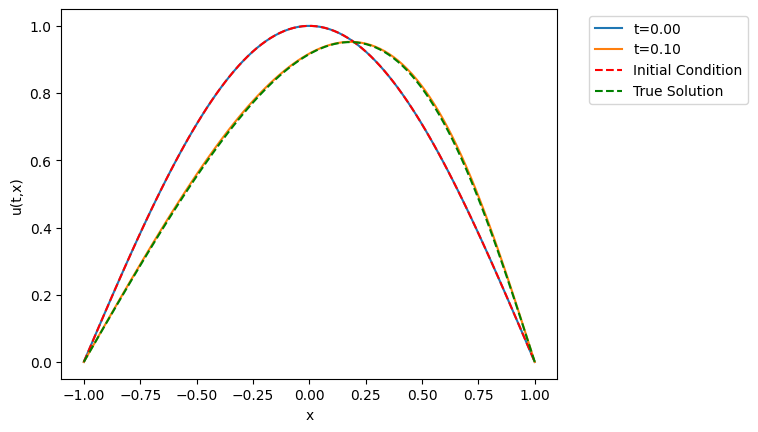

In [4]:
dim = 1
grid = np.expand_dims(np.linspace(-1, 1, 100), axis=0)
tmax = 1
time_list = [0, 0.1]

for time in time_list:
    t = time * np.ones((1, 100))
    x = grid
    
    grid_d_dim_with_t = np.concatenate([t.T, x.T], axis=1).astype('float32')
    
    pinn_sol = model.net(torch.from_numpy(grid_d_dim_with_t).to(device))
    
    initial = model.net.particular_solution(torch.from_numpy(grid_d_dim_with_t))
    
    plt.plot(grid[0], pinn_sol.cpu().detach().numpy()[:,0], label=f"t={time:.2f}")
plt.xlabel('x')
plt.ylabel('u(t,x)')
plt.plot(grid[0], initial[:, 0], 'r--', label='Initial Condition')
plt.plot(grid[0], exact_example(0, grid, 0.1), 'g--', label='True Solution')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [6]:
torch.save(model.net.state_dict(), '../logs/models/pinn_test_case_1_dim_1_model.pth')